In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType
from pyspark.sql.functions import col, year, hour, to_timestamp, desc, count

**Create a Spark session**

In [2]:
#Initializing the Spark session
crime_spark = SparkSession.builder.appName("ChicagoCrimeDataAnalytics").getOrCreate()

**Define the schema for loading the Chicago crime dataset (https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2/data).**

In [3]:
#Defining schema
crime_schema = StructType([
    StructField("ID", StringType(), True),
    StructField("Case Number", StringType(), True),
    StructField("Date", StringType(), True),
    StructField("Block", StringType(), True),
    StructField("IUCR", StringType(), True),
    StructField("Primary Type", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Location Description", StringType(), True),
    StructField("Arrest", StringType(), True),
    StructField("Domestic", StringType(), True),
    StructField("Beat", StringType(), True),
    StructField("District", StringType(), True),
    StructField("Ward", StringType(), True),
    StructField("Community Area", StringType(), True),
    StructField("FBI Code", StringType(), True),
    StructField("X Coordinate", StringType(), True),
    StructField("Y Coordinate", StringType(), True),
    StructField("Year", IntegerType(), True),
    StructField("Updated On", StringType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Location", StringType(), True)
])


**Load the Chicago crime data (you should get more than a million rows).**

In [4]:
#Loading the data
crime_data = crime_spark.read.csv("/content/Crimes_-_2001_to_Present_20250404.csv", header=True, schema=crime_schema)
crime_data.count()

8287103

In [5]:
crime_data.printSchema()
crime_data


root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



DataFrame[ID: string, Case Number: string, Date: string, Block: string, IUCR: string, Primary Type: string, Description: string, Location Description: string, Arrest: string, Domestic: string, Beat: string, District: string, Ward: string, Community Area: string, FBI Code: string, X Coordinate: string, Y Coordinate: string, Year: int, Updated On: string, Latitude: double, Longitude: double, Location: string]

In [6]:
crime_data.show()

+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|                Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|13311263|   JG503434|07/29/2022 03:39:...|     023XX S TROY ST|1582|OFFENSE INVOLVING...|   CHILD PORNOGRAPHY|           RE

**Clean the data:**

    Remove all null values.

    Change 'Date' column data type

In [7]:
#Cleaning and filtering the data
crime_cleaned = crime_data.dropna()



In [8]:
#changing the date data type
crime_cleaned = crime_cleaned.withColumn("Date", to_timestamp("Date", "MM/dd/yyyy hh:mm:ss a"))

**Filter the data for last ten years.**

In [9]:
crime_cleaned = crime_cleaned.filter(year("Date") >= 2016)

In [10]:
print("Row count after filtering for last 10 years:", crime_cleaned.count())
crime_cleaned.select("Date").orderBy("Date").show(5, truncate=False)  # Earliest date in filtered data


Row count after filtering for last 10 years: 2261410
+-------------------+
|Date               |
+-------------------+
|2016-01-01 00:00:00|
|2016-01-01 00:00:00|
|2016-01-01 00:00:00|
|2016-01-01 00:00:00|
|2016-01-01 00:00:00|
+-------------------+
only showing top 5 rows



**Remove all the records with the following crime types:**

    'NON-CRIMINAL (SUBJECT SPECIFIED)'
    'OTHER OFFENSE'
    'STALKING'
    'NON - CRIMINAL'
    'ARSON'

In [11]:
ignore_types = ['NON-CRIMINAL (SUBJECT SPECIFIED)', 'OTHER OFFENSE', 'STALKING', 'NON - CRIMINAL', 'ARSON']
crime_cleaned = crime_cleaned.filter(~col("Primary Type").isin(ignore_types))

**Merge the similar crime types.**

    For example, change 'Primary Type' of cases that have 'Primary Type' as ‘SEX OFFENSE’ or ‘PROSTITUTION’ such that they should have the same 'Primary Type'.

In [12]:
from pyspark.sql.functions import when

crime_cleaned = crime_cleaned.withColumn(
    "Primary Type",
    when(col("Primary Type").isin("SEX OFFENSE", "PROSTITUTION"), "SEXUAL RELATED")
    .otherwise(col("Primary Type"))
)

**Analyze the data and present results:**

    Show year-wise trend of the crime for last ten years.
    Find out at which hour of the day crime is highest.
    Find top ten crimes and present them as a bar chart.

In [13]:
#Year-wise crime count
yearwise_crime = crime_cleaned.groupBy(year("Date").alias("Year")).count().orderBy("Year")
yearwise_crime.show()

+----+------+
|Year| count|
+----+------+
|2016|248599|
|2017|246574|
|2018|245390|
|2019|240853|
|2020|193877|
|2021|187558|
|2022|219017|
|2023|243254|
|2024|238728|
|2025| 45695|
+----+------+



In [14]:
yearwise_crime_pd = yearwise_crime.toPandas()


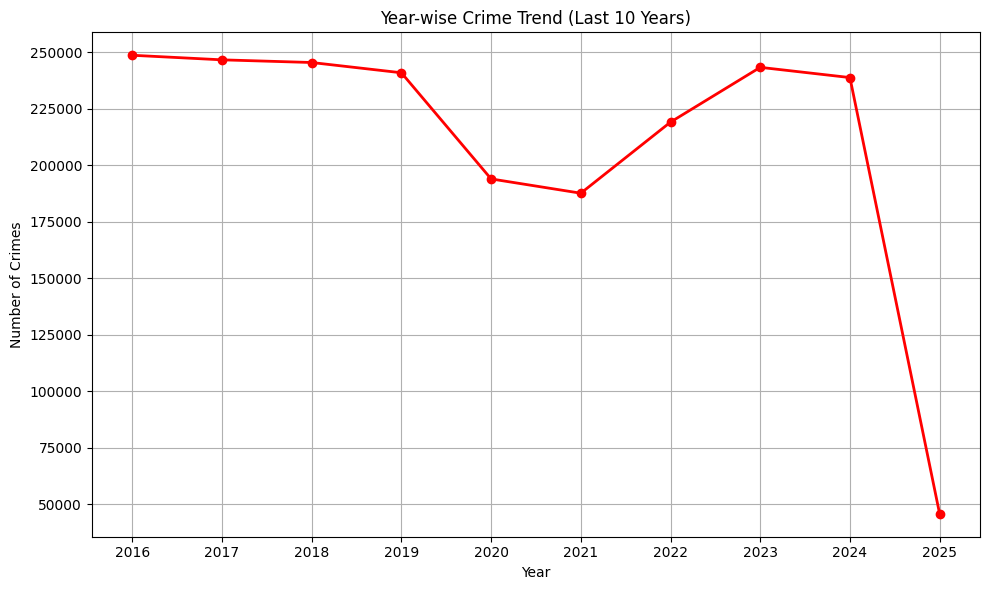

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(yearwise_crime_pd["Year"], yearwise_crime_pd["count"], color= 'red', marker='o', linestyle='-', linewidth=2)
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.title("Year-wise Crime Trend (Last 10 Years)")
plt.grid(True)
plt.xticks(yearwise_crime_pd["Year"])
plt.tight_layout()
plt.show()


In [18]:
#Hour with most crimes
hourly_crime = crime_cleaned.withColumn("Hour", hour("Date"))
hourly_crime.groupBy("Hour").count().orderBy(desc("count")).show(1)

+----+------+
|Hour| count|
+----+------+
|   0|124704|
+----+------+
only showing top 1 row



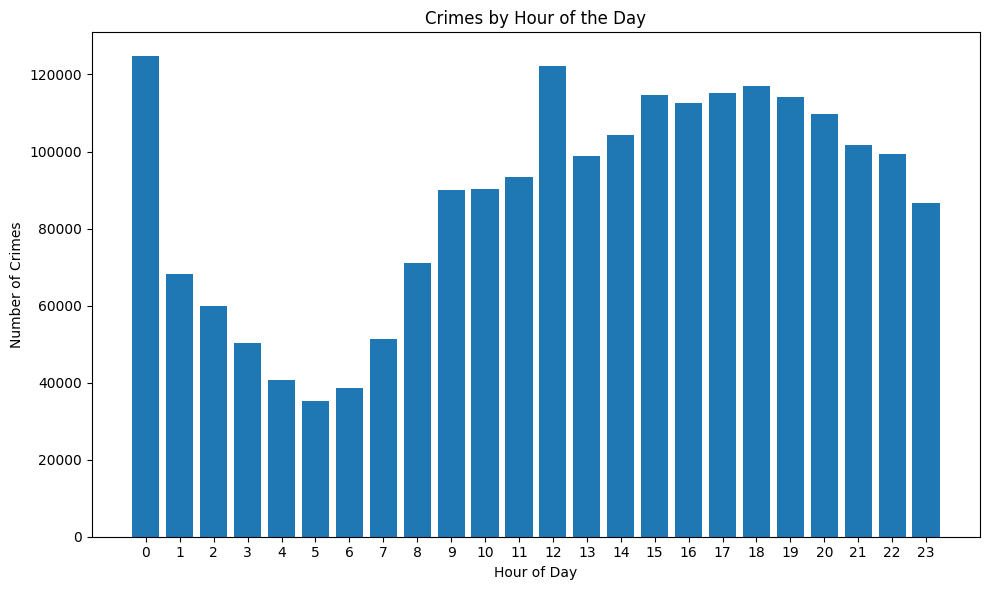

+----+------+
|Hour| count|
+----+------+
|   0|124704|
+----+------+
only showing top 1 row



In [19]:
from pyspark.sql.functions import hour, desc
import matplotlib.pyplot as plt

#Add 'Hour' column and grouping by it
hourly_crime = crime_cleaned.withColumn("Hour", hour("Date")) \
                             .groupBy("Hour") \
                             .count() \
                             .orderBy("Hour")

#Converting to Pandas
hourly_crime_pd = hourly_crime.toPandas()

#Plot Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(hourly_crime_pd["Hour"], hourly_crime_pd["count"])
plt.xlabel("Hour of Day")
plt.ylabel("Number of Crimes")
plt.title("Crimes by Hour of the Day")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

#Print the hour with the highest crime
crime_cleaned.withColumn("Hour", hour("Date")) \
             .groupBy("Hour") \
             .count() \
             .orderBy(desc("count")) \
             .show(1)



In [20]:
#Top 10 crime types
top_crime_types = crime_cleaned.groupBy("Primary Type").count().orderBy(desc("count")).limit(10)
top_crime_types.show()

+-------------------+------+
|       Primary Type| count|
+-------------------+------+
|              THEFT|512563|
|            BATTERY|419773|
|    CRIMINAL DAMAGE|254310|
|            ASSAULT|188431|
| DECEPTIVE PRACTICE|147632|
|MOTOR VEHICLE THEFT|137636|
|           BURGLARY| 88798|
|            ROBBERY| 87627|
|          NARCOTICS| 81234|
|  WEAPONS VIOLATION| 63718|
+-------------------+------+



<ipython-input-23-fb5e17078128>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("Reds")


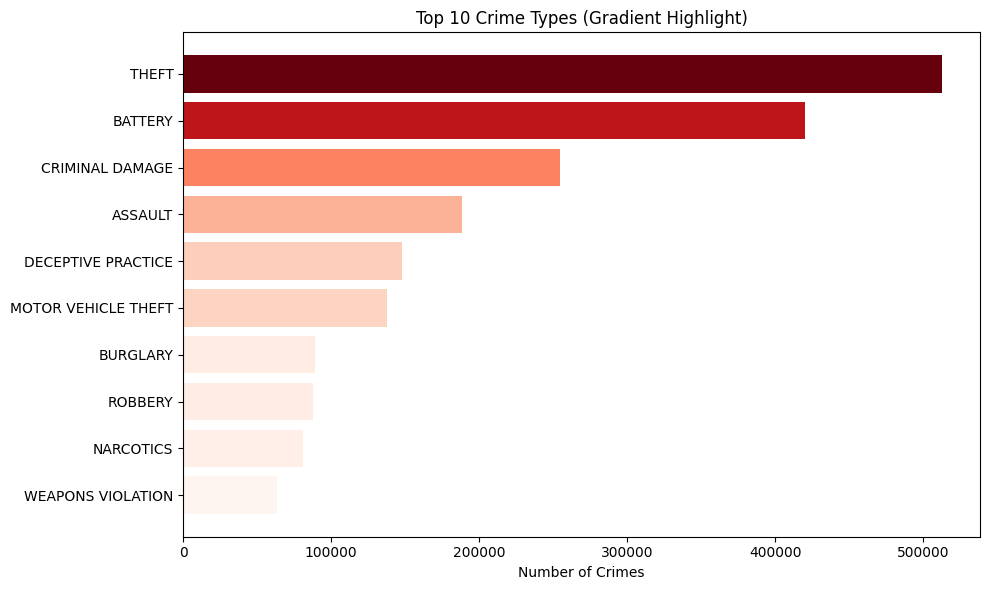

In [23]:
import matplotlib.pyplot as plt
import numpy as np

#Convert Spark DataFrame to Pandas
top_crime_types_pd = top_crime_types.toPandas()

# Sort for better horizontal bar chart layout
top_crime_types_pd = top_crime_types_pd.sort_values("count", ascending=True)

# Normalize the count values between 0 and 1
norm = (top_crime_types_pd["count"] - top_crime_types_pd["count"].min()) / \
       (top_crime_types_pd["count"].max() - top_crime_types_pd["count"].min())

# Map normalized values to a colormap (e.g., 'Blues')
from matplotlib.cm import get_cmap
cmap = get_cmap("Reds")
bar_colors = [cmap(x) for x in norm]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_crime_types_pd["Primary Type"], top_crime_types_pd["count"], color=bar_colors)
plt.xlabel("Number of Crimes")
plt.title("Top 10 Crime Types (Gradient Highlight)")
plt.tight_layout()
plt.show()
